# FGVC Aircraft — Učitavanje i pretprocesiranje

U ovoj fazi se vrši:
1. **Učitavanje FGVC Aircraft dataset-a** koji sadrži 100 klasa aviona.  
2. **Filtriranje** na 10 najzastupljenijih klasa koje će se koristiti za treniranje.  
3. **Stratifikovana podela** podataka na train/validation/test skupove, tako da je svaka klasa proporcionalno zastupljena u svim delovima.  
4. **Pretprocesiranje slika** pomoću generatora koji vrše:
    - **resize** (promenu dimenzija slika na 128×128 piksela),
    - **normalizaciju** vrednosti piksela (0–1),
    - i **augmentaciju** (rotacije, flip, zoom) za povećanje raznovrsnosti train skupa.


## 0) Podešavanje putanja i import modula
Ova ćelija podešava radni direktorijum tako da se folder `src/` pravilno vidi u Python putanji.  
Ovim se omogućava uvoz sopstvenih modula iz projekta.


In [28]:

import sys
from pathlib import Path

# ako si u notebooks/, ovo ide jedan nivo iznad = root projekta
ROOT = Path.cwd().resolve().parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print("PYTHONPATH ok:", ROOT)
print("src postoji:", (ROOT / "src").exists())


PYTHONPATH ok: C:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM
src postoji: True


## 1) Učitavanje i spajanje mapa
Učitavamo train/val/test mape (`images_variant_*.txt`) iz FGVC Aircraft dataset-a, dodajemo `.jpg` ekstenzije, 
i formiramo pune putanje do fajlova sa slikama.  
Na kraju proveravamo koliko ukupno slika postoji i prikazujemo nekoliko primera.


In [29]:
from pathlib import Path
import pandas as pd

BASE = Path("../data/raw/fgvc-aircraft-2013b")
DATA = BASE / "data"
IMAGES = DATA / "images"

def read_map(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line=line.strip()
            if not line: continue
            img,label = line.split(" ",1)
            rows.append((img,label))
    return pd.DataFrame(rows, columns=["image","label"])

def normalize_image_name(x: str) -> str:
    x = x.strip().replace("\\", "/")
    if x.lower().startswith("images/"):
        x = x[7:]
    if not x.lower().endswith(".jpg"):
        x = x + ".jpg"
    return x

TRAIN_MAP = DATA/"images_variant_train.txt"
VAL_MAP   = DATA/"images_variant_val.txt"
TEST_MAP  = DATA/"images_variant_test.txt"

DF = pd.concat([read_map(TRAIN_MAP), read_map(VAL_MAP), read_map(TEST_MAP)], ignore_index=True)
DF["filepath"] = DF["image"].apply(lambda x: str((IMAGES/normalize_image_name(x)).resolve()))

# zadrži samo postojeće fajlove
DF = DF[[Path(p).exists() for p in DF["filepath"]]].reset_index(drop=True)

print("Ukupno slika:", len(DF))
DF.head()


Ukupno slika: 10000


,image,label,filepath
0,1025794,707-320,C:\Users\Emilija\Desktop\AircraftClassifier_CN...
1,1340192,707-320,C:\Users\Emilija\Desktop\AircraftClassifier_CN...
2,0056978,707-320,C:\Users\Emilija\Desktop\AircraftClassifier_CN...
3,0698580,707-320,C:\Users\Emilija\Desktop\AircraftClassifier_CN...
4,0450014,707-320,C:\Users\Emilija\Desktop\AircraftClassifier_CN...


## 2) Filtriranje i stratifikovana podela
Biramo 10 najzastupljenijih klasa iz dataset-a i vršimo podelu u odnosu 70% train, 15% val, 15% test.  
Koristimo stratifikaciju kako bi svaka klasa bila proporcionalno zastupljena u svim skupovima.


In [30]:
from src.dataset_loader import pick_top_k_classes, stratified_split, save_splits

DF10 = pick_top_k_classes(DF, k=10)
print("Za 10 klasa:", DF10['label'].nunique(), " | redova:", len(DF10))

train_df, val_df, test_df = stratified_split(DF10, 0.7, 0.15, 0.15, seed=42)
print(len(train_df), len(val_df), len(test_df))

save_splits(train_df, val_df, test_df, "../data/processed")


Za 10 klasa: 10  | redova: 1000
700 150 150


**Zaključak:** Dobijena je podela od 700/150/150 primera uz 10 klasa, što potvrđuje balansiran dataset.


## 3) Kreiranje generatora za pretprocesiranje slika
Sledeći korak je priprema generatora za slike pomoću `ImageDataGenerator` iz Keras-a.  
Generatori automatski vrše:
- **resize** slika na 128×128 piksela,  
- **normalizaciju** piksela na [0,1],  
- **augmentaciju** (rotacije, pomeranja, zoom, horizontalni flip) — *samo na train skupu.*


In [25]:
from src.preprocessing import make_datagens, flow_from_dataframe
import matplotlib.pyplot as plt
import json, os

IMG_SIZE = (128, 128)
BATCH = 16


Kreiramo train i evaluacione (val/test) generatore.


In [26]:
train_gen, eval_gen = make_datagens(img_size=IMG_SIZE)


## 4) Generisanje train/val/test tokova (flow)
Pomoću `flow_from_dataframe` kreiramo tokove slika direktno iz DataFrame-ova.  
Ovim dobijamo povezane slike i labele koje se mogu direktno koristiti u treniranju CNN modela.


In [27]:
train_flow = flow_from_dataframe(train_gen, train_df, img_size=IMG_SIZE, batch_size=BATCH, shuffle=True)
val_flow   = flow_from_dataframe(eval_gen,  val_df,   img_size=IMG_SIZE, batch_size=BATCH, shuffle=False)
test_flow  = flow_from_dataframe(eval_gen,  test_df,  img_size=IMG_SIZE, batch_size=BATCH, shuffle=False)

n_classes = len(train_flow.class_indices)
n_classes


Found 700 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.


10

Sačuvamo mapiranje klasa u JSON fajl (`class_indices.json`) da bismo ga kasnije koristili pri evaluaciji modela i interpretaciji rezultata.


In [21]:
os.makedirs("../data/processed", exist_ok=True)
with open("../data/processed/class_indices.json", "w", encoding="utf-8") as f:
    json.dump(train_flow.class_indices, f, ensure_ascii=False, indent=2)
train_flow.class_indices


{'707-320': 0,
 '727-200': 1,
 '737-200': 2,
 '737-300': 3,
 '737-400': 4,
 '737-500': 5,
 '737-600': 6,
 '737-700': 7,
 '737-800': 8,
 '737-900': 9}

## 5) Vizuelna provera augmentacije
Prikazujemo nekoliko primera iz jednog batch-a kako bismo proverili da li augmentacija radi ispravno.  
Očekuju se rotirane, zumirane i „flipovane“ slike u odnosu na original.


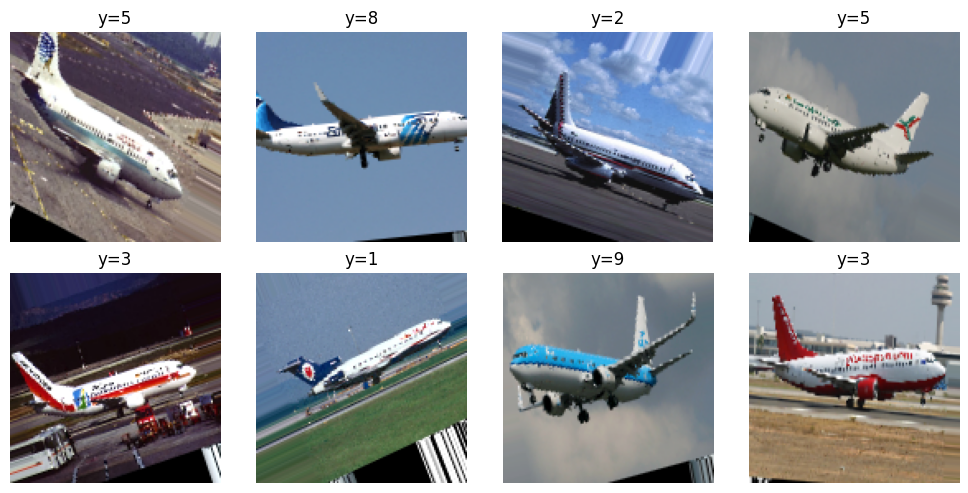

In [22]:
images, labels = next(train_flow)

fig, axes = plt.subplots(2, 4, figsize=(10,5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])
    ax.set_title(f"y={int(labels[i])}")
    ax.axis("off")
plt.tight_layout(); plt.show()


**Zaključak:** Augmentacija i resize funkcionišu korektno; slike su jasno prikazane u formatu 128×128.  
Dataset je spreman za treniranje CNN modela u sledećem koraku.
